# DKIST/DL-NIRSP Post-Processing Example

In [1]:
import dkist
import astropy.units as u

from sunpy.net import Fido, attrs as a
import sunpy.map
from astropy.time import Time

from scipy.interpolate import griddata

from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datadir = '/Users/sjaeggli/Projects/Data/DKIST/data1772'
recid = 'ZYFKAU'

## Read in the tiled dataset

In [3]:
## Find ASDF file
asdf_file = glob('{:}/{:}/*.asdf'.format(datadir, recid))

## Load ASDF dataset
dss = dkist.load_dataset(asdf_file)

In [4]:
dss

This DL-NIRSP Dataset is an array of (29, 13) Dataset objects and
consists of 1508 frames.
Files are stored in /Users/sjaeggli/Projects/Data/DKIST/data1772/ZYFKAU

This calibration has Dataset ID ZYFKAU.
The unique identifier for the input observe frames (Product ID) is L1-RWEJL.

Each Dataset has 4 pixel and 4 world dimensions.

The data are represented by a <class 'dask.array.core.Array'> object:
dask.array<stack, shape=(4, 246, 68, 54), dtype=float32, chunksize=(1, 246, 68, 54), chunktype=numpy.ndarray>

Array Dim  Axis Name                  Data size  Bounds
        0  polarization state                 4  None
        1  dispersion axis                  246  None
        2  helioprojective latitude          68  None
        3  helioprojective longitude         54  None

World Dim  Axis Name                  Physical Type                   Units
        3  stokes                     phys.polarization.stokes        unknown
        2  wavelength                 em.wl                 

## Explore the dataset

In [5]:
## Get number of X and Y tiles in dataset
nXtiles,nYtiles = dss.shape
nS,nW,nY,nX = dss[0,0].data.shape

print('Number of X Tiles:', nXtiles)
print('Number of Y Tiles:', nYtiles)
print(dss[0,0].wcs.pixel_axis_names) #these are listed in reverse order with respect to indexing in python
print('Number of Stokes Parameters:', nS)
print('Number of Wavelength Pixels:', nW)
print('Number of Spatial Y Pixels:', nY)
print('Number of Spatial X Pixels:', nX)
print('Waveband:', dss[0,0].headers[0]['WAVEBAND'])

Number of X Tiles: 29
Number of Y Tiles: 13
('helioprojective longitude', 'helioprojective latitude', 'dispersion axis', 'polarization state')
Number of Stokes Parameters: 4
Number of Wavelength Pixels: 246
Number of Spatial Y Pixels: 68
Number of Spatial X Pixels: 54
Waveband: Fe I (1565.0 nm)


In [6]:
xt0 = int(nXtiles/2)
yt0 = int(nYtiles/2)
x0 = int(nX/4)
w0 = 70 #spectral pixel in the blue wing of Stokes V profile

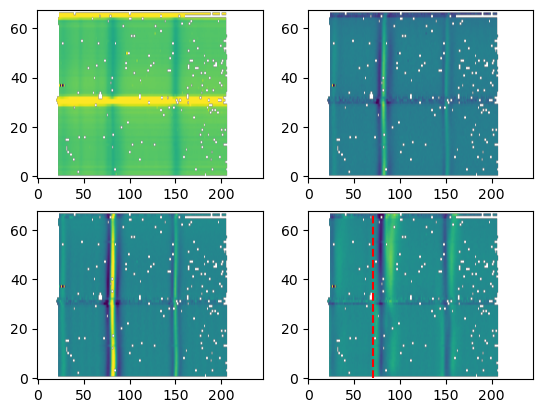

In [7]:
spec_img = dss[xt0,yt0][:,:,:,x0].data.compute()

fig,axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()

axs[0].imshow(spec_img[0,:,:].transpose(), origin='lower', vmin=0, vmax=1.2)
axs[1].imshow(spec_img[1,:,:].transpose(), origin='lower', vmin=-0.05, vmax=0.05)
axs[2].imshow(spec_img[2,:,:].transpose(), origin='lower', vmin=-0.05, vmax=0.05)
axs[3].imshow(spec_img[3,:,:].transpose(), origin='lower', vmin=-0.05, vmax=0.05)

for ax in axs:
    ax.set_aspect('auto')

plt.plot([w0,w0], [0,nY-1], 'r--')

plt.show()

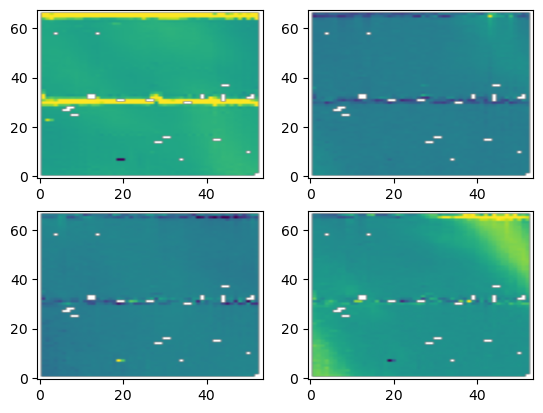

In [8]:
spat_img = dss[xt0,yt0][:,w0,:,:].data.compute()

fig,axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()

axs[0].imshow(spat_img[0,:,:], origin='lower', vmin=0, vmax=1.5)
axs[1].imshow(spat_img[1,:,:], origin='lower', vmin=-0.05, vmax=0.05)
axs[2].imshow(spat_img[2,:,:], origin='lower', vmin=-0.05, vmax=0.05)
axs[3].imshow(spat_img[3,:,:], origin='lower', vmin=-0.05, vmax=0.05)

for ax in axs:
    ax.set_aspect('auto')

In [9]:
#make a coarse map using the average intensity for each mosaic tile
minimap_I = np.zeros([nYtiles,nXtiles])
minimap_V = np.zeros([nYtiles,nXtiles])

for yi in range(0,nYtiles):
    for xi in range(0,nXtiles):
        minimap_I[yi,xi] = np.nanmean(dss[xi,yi].data[0,:,:,:]) #stokes I
        minimap_V[yi,xi] = np.nanmean(dss[xi,yi].data[3,w0,:,:]) #stokes V

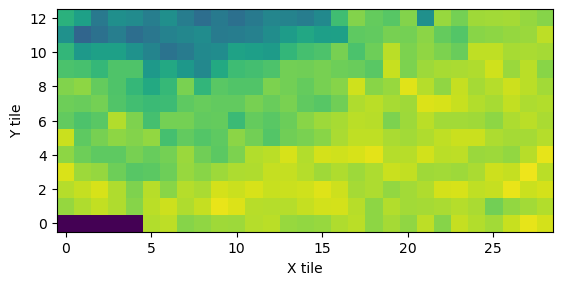

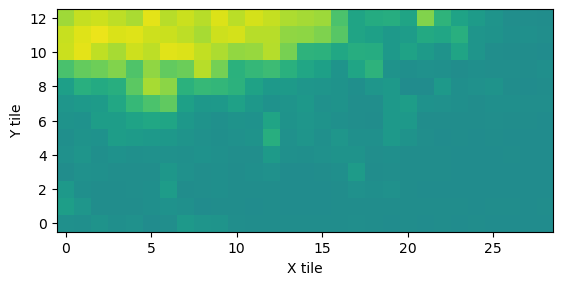

In [10]:
plt.imshow(minimap_I, origin='lower', vmin=0.5, vmax=1.1)
plt.xlabel('X tile')
plt.ylabel('Y tile')
plt.show()

plt.imshow(minimap_V, origin='lower', vmin=-0.1, vmax=0.1)
plt.xlabel('X tile')
plt.ylabel('Y tile')
plt.show()

## Ad Hoc Flat Field using local quiet Sun
Correct the mosaic using a flatfield made from the quiet sun tiles

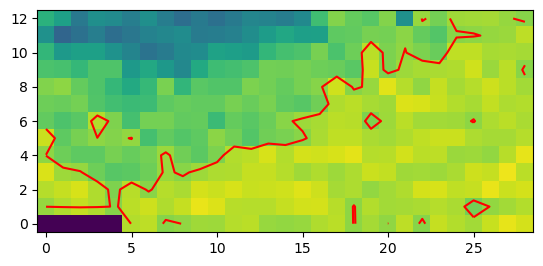

In [11]:
#Use the minimap to define a mask for the tiled dataset
thresh_qs = 1.0
mask_qs = (minimap_I > thresh_qs).transpose() #transpose mask to apply to tiled dataset

plt.imshow(minimap_I, origin='lower', vmin=0.5, vmax=1.1)
plt.contour(minimap_I, levels=[thresh_qs], colors=['red'])

plt.show()

In [12]:
#make an average tile from all the Stokes I quiet sun tiles
#average over the spectral dimension, leaving just the two spatial dimensions for each tile
avg_tile = np.zeros([nY,nX])
count = 0

for ds in dss[mask_qs]:
    avg_tile += np.nanmean(ds.data[0,:,:,:].compute(), axis=0)
    count += 1

avg_tile /= count

/var/folders/tk/4ztr44zd507_0fl_zvcjk8k00000gn/T/ipykernel_69390/3805661568.py:7: RuntimeWarning: Mean of empty slice
  avg_tile += np.nanmean(ds.data[0,:,:,:].compute(), axis=0)


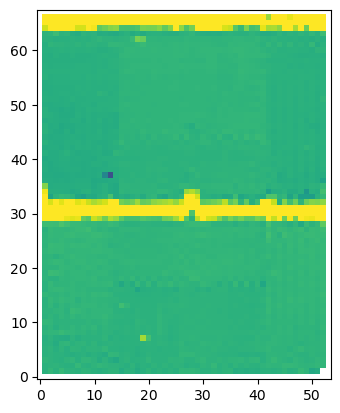

In [13]:
#show the average tile
plt.imshow(avg_tile, origin='lower', vmin=0.5, vmax=1.2)
plt.show()

## Make a basic quicklook

In [14]:
#Calculate the quicklook metrics and extract the world coordinates
#for every spatial pixel in the dataset
cont_w0,cont_w1 = (50, 60)
line_w0,line_w1 = (60, 80)

dl_Tx = np.zeros([nXtiles,nYtiles,nY,nX])
dl_Ty = np.zeros([nXtiles,nYtiles,nY,nX])
dl_cont = np.zeros([nXtiles,nYtiles,nY,nX])
dl_stkv = np.zeros([nXtiles,nYtiles,nY,nX])

for iXt in range(0,nXtiles):
    for iYt in range(0,nYtiles):
        ds = dss[iXt,iYt]

        dl_coord = ds[0,0,:,:].axis_world_coords()
        dl_coord = dl_coord[0]
        dl_Tx[iXt,iYt,:,:] = dl_coord.Tx.value
        dl_Ty[iXt,iYt,:,:] = dl_coord.Ty.value
        
        dl_cont[iXt,iYt,:,:] = np.nanmean(ds[0,cont_w0:cont_w1,:,:].data, axis=0) / avg_tile
        dl_stkv[iXt,iYt,:,:] = np.nanmean(ds[3,line_w0:line_w1,:,:].data, axis=0) / avg_tile

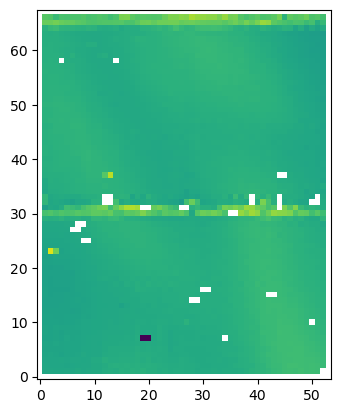

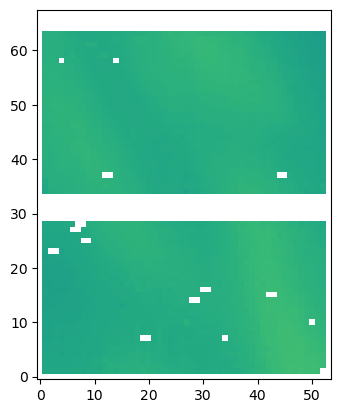

In [15]:
#Define a tile mask to reduce edge effects further
tile_mask = np.ones([nY,nX])
tile_mask[29:34,:] = np.nan
tile_mask[64:68,:] = np.nan
tile_mask[7,19:21] = np.nan
tile_mask[23,2:4] = np.nan
tile_mask[37,12:14] = np.nan

spat_img = dss[xt0,yt0][0,w0,:,:].data.compute()

plt.imshow(spat_img/avg_tile, origin='lower', vmin=0, vmax=1.5)
plt.show()

plt.imshow(spat_img/avg_tile*tile_mask, origin='lower', vmin=0, vmax=1.5)
plt.show()

In [16]:
#remap data in solar coordinates
#set up a new common coordinate grid for the whole mosaic
x0 = dl_Tx.min()
x1 = dl_Tx.max()
y0 = dl_Ty.min()
y1 = dl_Ty.max()

dx = dss[0,0].headers[0]['CDELT1'] #nominal arcsec/pixel scale
dy = dss[0,0].headers[0]['CDELT2']

new_nX = int((x1-x0)/dx)
new_nY = int((y1-y0)/dy)

new_xcoord,new_ycoord = np.meshgrid(np.mgrid[0:new_nX]*dx+x0,
                                    np.mgrid[0:new_nY]*dy+y0)
        
xy_out = np.array([new_xcoord.flatten(), 
                   new_ycoord.flatten()]).transpose()

#remap the continuum
good = np.isfinite(dl_cont*tile_mask)

values_in = dl_cont[good]
xy_in = np.array([dl_Tx[good], dl_Ty[good]]).transpose()

#"nearest" is fast but produces some weird edge effects,
#"linear" treatment of missing edge data is better, but takes more time
values_out = griddata(xy_in, values_in, xy_out, method='linear') 
dlremap_cont = values_out.reshape(new_nY,new_nX)

#remap the Stokes V
good = np.isfinite(dl_stkv*tile_mask)

values_in = dl_stkv[good]
xy_in = np.array([dl_Tx[good], dl_Ty[good]]).transpose()

values_out = griddata(xy_in, values_in, xy_out, method='linear')
dlremap_stkv = values_out.reshape(new_nY,new_nX)

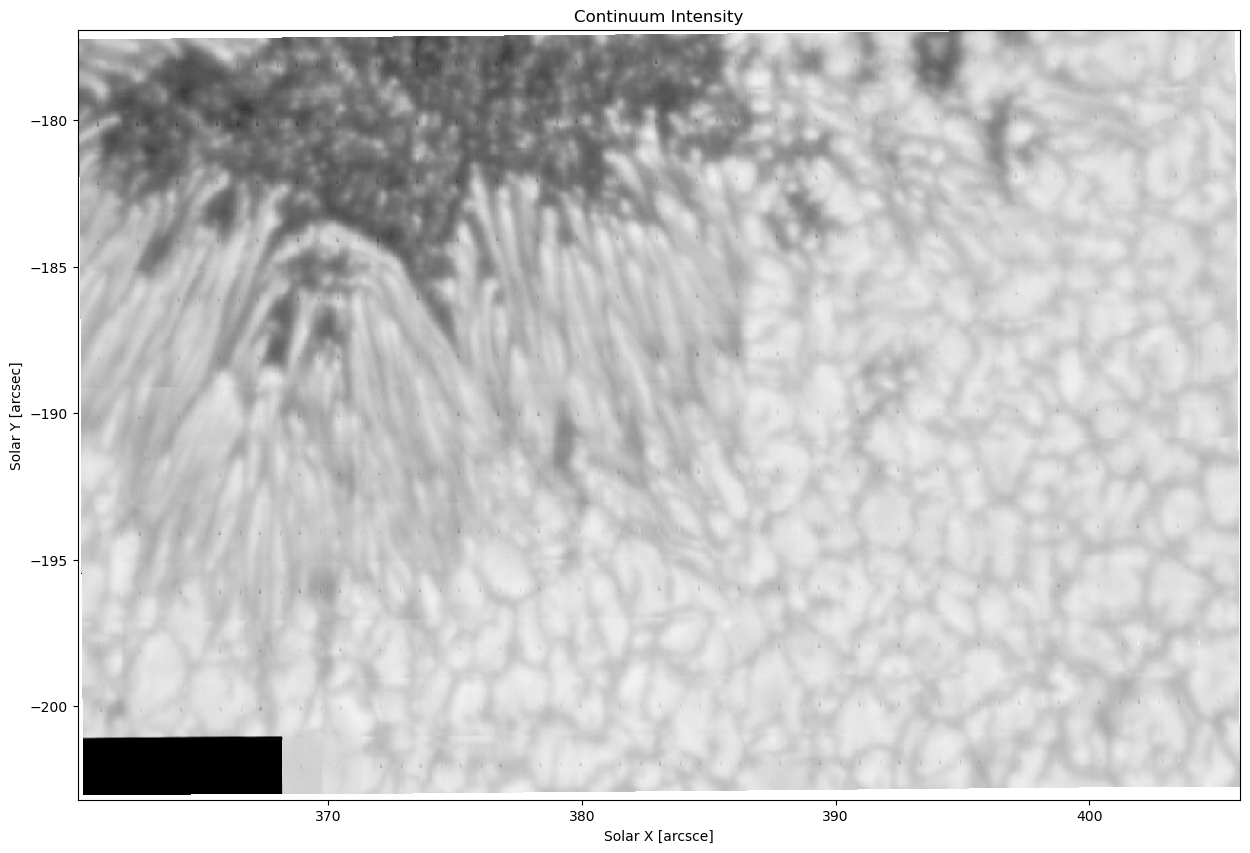

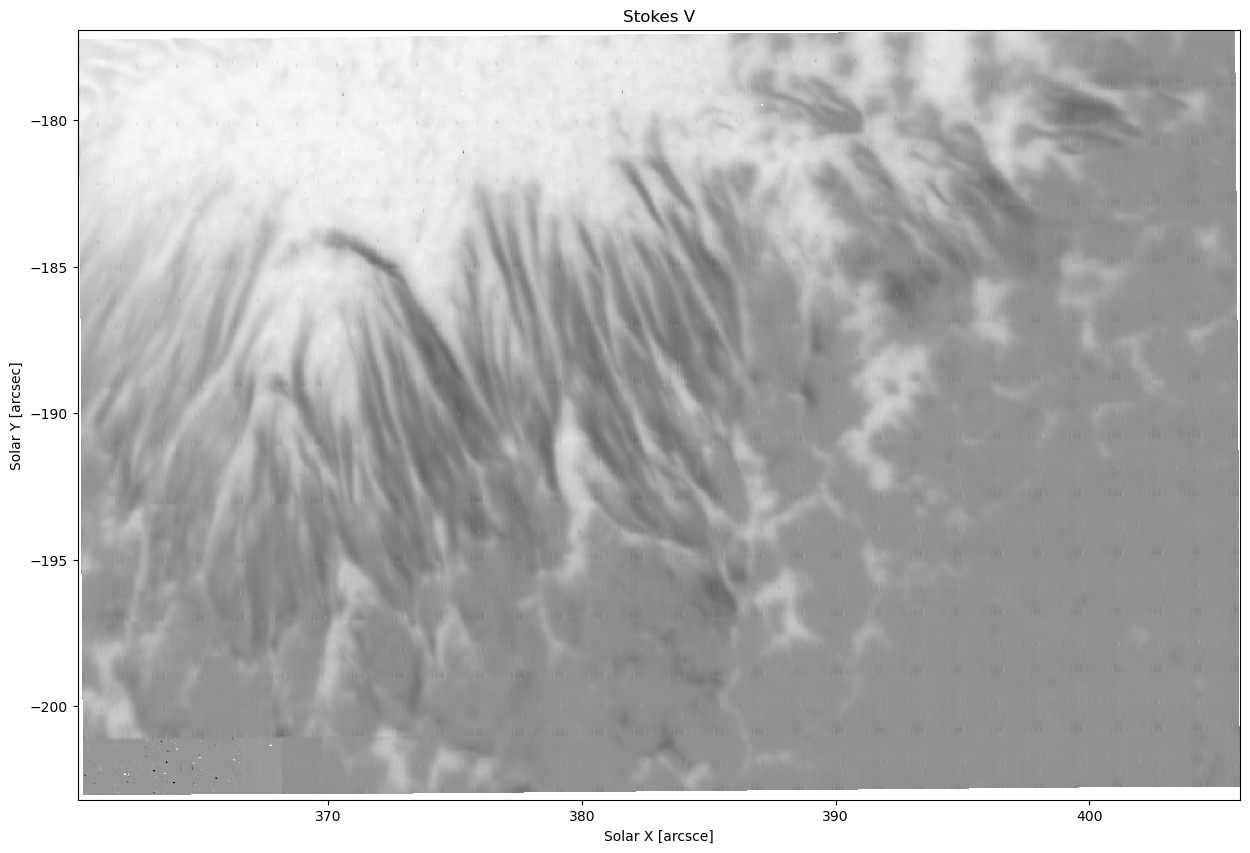

In [17]:
fig = plt.figure(figsize=(15,10))
plt.pcolormesh(new_xcoord, new_ycoord, dlremap_cont, vmin=0.5, vmax=1.2, cmap='Greys_r')
plt.xlabel('Solar X [arcsce]')
plt.ylabel('Solar Y [arcsec]')
plt.title('Continuum Intensity')
plt.show()

fig = plt.figure(figsize=(15,10))
plt.pcolormesh(new_xcoord, new_ycoord, dlremap_stkv, vmin=-0.05, vmax=0.05, cmap='Greys_r')
plt.xlabel('Solar X [arcsce]')
plt.ylabel('Solar Y [arcsec]')
plt.title('Stokes V')
plt.show()